#### 1. Setup

In [2]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans # K-means clustering

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm import tqdm

In [3]:
# if GPU is available, then use
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


In [4]:
data_dir = "../../datasets/cityscapes_data"

train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")

train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)

print(len(train_fns), len(val_fns))

2975 500


#### 2. Analyze

../../datasets/cityscapes_data/train/973.jpg


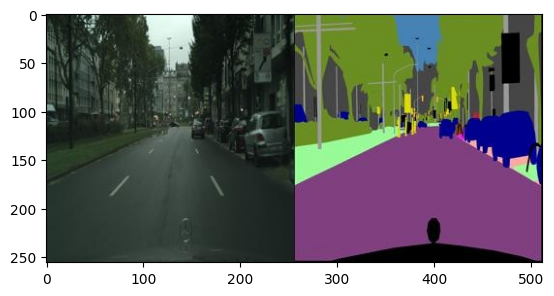

In [5]:
sample_image_fp = os.path.join(train_dir, train_fns[0])
sample_image = Image.open(sample_image_fp).convert("RGB")
plt.imshow(sample_image)
print(sample_image_fp)

In [6]:
def split_image(image):
    image = np.array(image) # NumPy array (Height, Width, Channels)
    # Resizing
    cityscape, label = image[:, :256, :], image[:, 256:, :]
    return cityscape, label

(256, 512, 3)
0 255 0 255


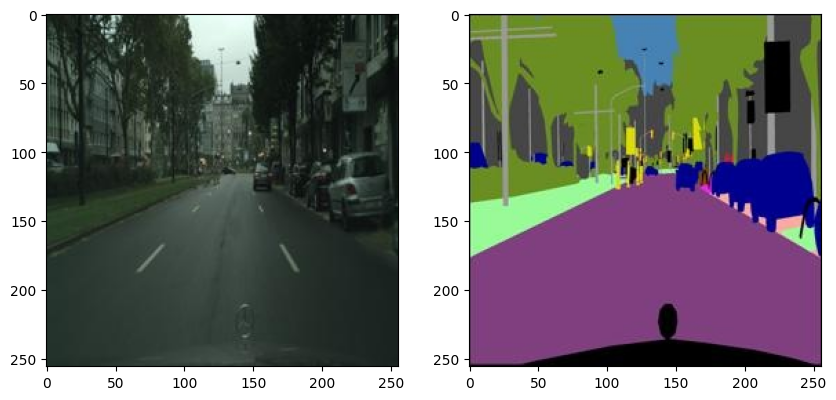

In [7]:
sample_image = np.array(sample_image)
print(sample_image.shape) # output: (H, W, C)

cityscape, label = split_image(sample_image)
# cityscape.shape==(H, W/2, C), label.shape==(H, W/2, C)
print(cityscape.min(), cityscape.max(), label.min(), label.max())

# NumPy array -> PIL image
cityscape, label = Image.fromarray(cityscape), Image.fromarray(label)

# present image
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)

#### 3. Define Labels

In [8]:
# Output Label
num_items = 1000

# randomly choose a number between 0 and 255, 1000 times
color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)
print(color_array.shape) # (1000, 3): RGB 3-chanels vector x 1000
print(color_array[:5, :]) # RGB of 5 samples

(1000, 3)
[[  0 134 130]
 [121 221 129]
 [  3  66  16]
 [ 75  75  29]
 [ 66  43 160]]


In [9]:
num_classes = 10

# store in label_model by K-means clustering
label_model = KMeans(n_clusters=num_classes, n_init='auto')
label_model.fit(color_array) # train Model

KMeans(n_clusters=10, n_init='auto')

In [10]:
label_model.predict(color_array[:5, :]) # predict clustering index(0~9) of 5 samples

array([5, 8, 5, 7, 0], dtype=int32)

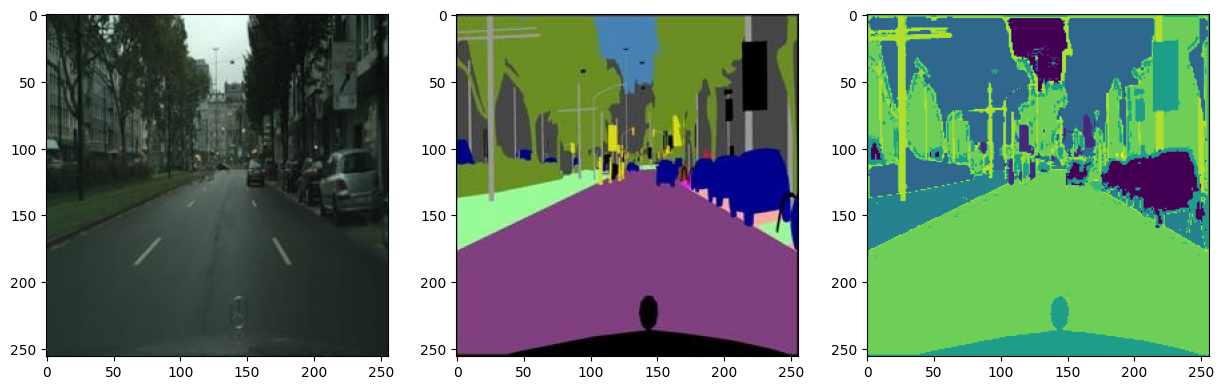

In [11]:
cityscape, label = split_image(sample_image)
label_class = label_model.predict(label.reshape(-1, 3)).reshape(256, 256)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class) # result of K-means clustering

In [12]:
label_class

array([[5, 5, 5, ..., 5, 5, 5],
       [5, 7, 7, ..., 7, 7, 5],
       [5, 8, 8, ..., 8, 8, 5],
       ...,
       [5, 7, 7, ..., 7, 7, 7],
       [5, 7, 7, ..., 7, 7, 7],
       [5, 5, 5, ..., 5, 7, 5]], dtype=int32)

#### 4. Define Dataset

In [13]:
class CityscapeDataset(Dataset):
    def __init__(self, image_dir, label_model):
        self.image_dir = image_dir
        self.image_fns = os.listdir(image_dir)
        self.label_model = label_model

    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.image_dir, image_fn) # file path
        image = Image.open(image_fp)
        image = np.array(image)
        cityscape, label = self.split_image(image)
        label_class = self.label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
        label_class = torch.Tensor(label_class).long()
        cityscape = self.transform(cityscape)
        return cityscape, label_class
    
    def split_image(self, image) :
        image = np.array(image)
        cityscape, label = image[ : , :256, : ], image[ : , 256: , : ]
        return cityscape, label
    
    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.56, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [14]:
dataset = CityscapeDataset(train_dir, label_model)
print(len(dataset))

cityscape, label_class = dataset[0]
print(cityscape.shape)
print(label_class.shape)

2975
torch.Size([3, 256, 256])
torch.Size([256, 256])


#### 5. U-Net
UNet 논문에서는 3x3 convolutional block을 거칠 때마다 feature map의 크기가 2씩 감소하는데, 아래 코드에서는 convolutional block에 크기 1의 패딩을 넣어서 feature map의 크기가 감소하는 것을 방지함 (maxpooling에 의해서 줄어드는 것은 동일)

In [15]:
class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)

    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.BatchNorm2d(num_features=out_channels),
                nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.BatchNorm2d(num_features=out_channels))
        return block

    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

In [16]:
model = UNet(num_classes=num_classes)

data_loader = DataLoader(dataset, batch_size=4)
print(len(dataset), len(data_loader))

X, Y = next(iter(data_loader))
print(X.shape)
print(Y.shape)

2975 744
torch.Size([4, 3, 256, 256])
torch.Size([4, 256, 256])


- X 값은 4개의 배치 사이즈 / 3개의 채널 / 높이 256 / 너비 256
- Y 값은 4개의 배치 사이즈 / 높이 256 / 너비 256

##### 6. Training Model

In [17]:
batch_size = 4

epochs = 10
lr = 0.01

dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size = batch_size)

model = UNet(num_classes = num_classes).to(device)

# define loss-function
criterion = nn.CrossEntropyLoss()
# define Optimizer
optimizer = optim.Adam(model.parameters(), lr = lr)


step_losses = []
epoch_losses = []

for epoch in tqdm(range(epochs)) :
  epoch_loss = 0
  
  for X, Y in tqdm(data_loader, total = len(data_loader), leave = False) :
    X, Y = X.to(device), Y.to(device)
    optimizer.zero_grad()
    Y_pred = model(X)
    loss = criterion(Y_pred, Y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    step_losses.append(loss.item())
  epoch_losses.append(epoch_loss/len(data_loader))

100%|██████████| 10/10 [36:41<00:00, 220.19s/it]


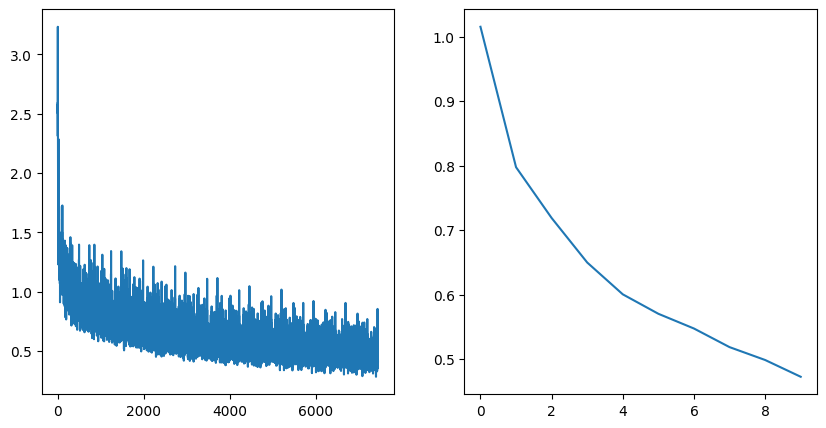

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(step_losses) # 1 batch 당 발생하는 loss
axes[1].plot(epoch_losses) # 1 epoch의 모든 batch의 loss를 평균한 값

plt.show()

In [24]:
# 학습된 모델 저장
model_name = "UNet_10.pth"
model_path = "./models/" + model_name
torch.save(model.state_dict(), model_path)

##### 7. Test Model

In [25]:
model_ = UNet(num_classes=num_classes).to(device)
model_.load_state_dict(torch.load(model_path))

/tmp/ipykernel_23720/1874698567.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [26]:
test_batch_size = 8
dataseet = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

X, Y = next(iter(data_loader))
X, Y = X.to(device), Y.to(device)
Y_pred = model_(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([8, 10, 256, 256])
torch.Size([8, 256, 256])


In [27]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


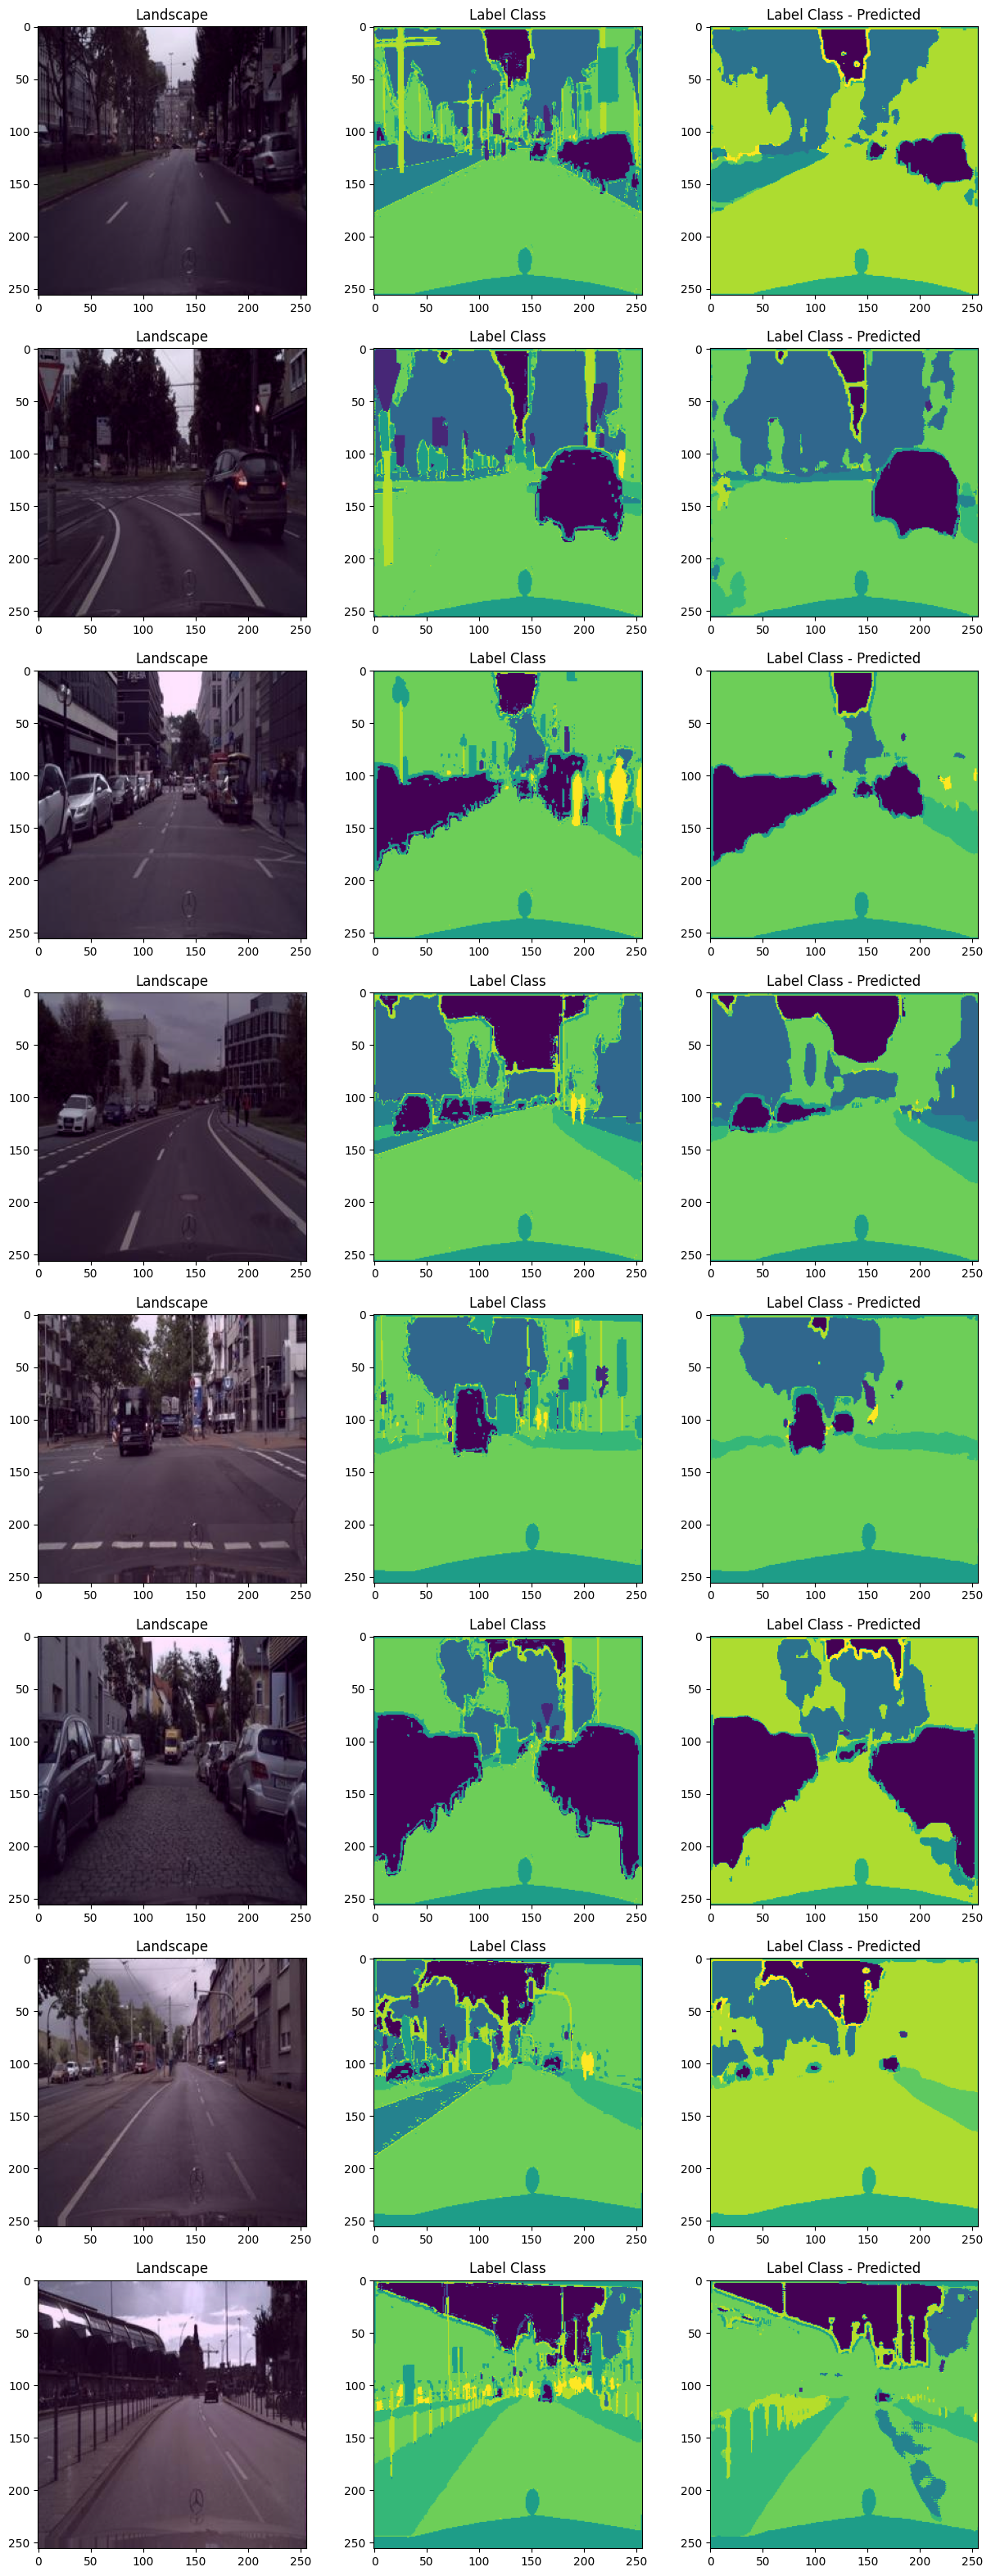

In [28]:
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))
 
iou_scores = []
 
for i in range(test_batch_size):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    # IOU score
    intersection = np.logical_and(label_class, label_class_predicted)
    union = np.logical_or(label_class, label_class_predicted)
    iou_score = np.sum(intersection) / np.sum(union)
    iou_scores.append(iou_score)
 
    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")
 
plt.show()

##### 8. IoU Score

In [29]:
print(sum(iou_scores) / len(iou_scores))

0.9758966835365007


---

&copy; [Jarvis_Geun: U-Net 실습](https://velog.io/@jarvis_geun/U-Net-%EC%8B%A4%EC%8A%B5)

&copy; [CodeCrafter: U-Net 모델 구현하기](https://jaylala.tistory.com/entry/%EB%94%A5%EB%9F%AC%EB%8B%9D-with-%ED%8C%8C%EC%9D%B4%EC%8D%AC-U-Net-%EB%AA%A8%EB%8D%B8-%EA%B5%AC%ED%98%84%ED%95%98%EA%B8%B0-Semantic-Segmentation)